In [1]:
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime
import pickle

######################################################################

from lazypredict.Supervised import LazyRegressor

from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuitCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

######################################################################

import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

######################################################################

pd.set_option('display.max_columns', 999)

import warnings
warnings.filterwarnings('ignore')

######################################################################

import sys
sys.path.insert(0, 'src/')
from modeling import *


In [2]:
df = pd.read_csv('cleaned_players_df.csv')
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,2020-21
0,P.K. Subban,Defenseman,1989,32,Toronto,ON,CAN,"6' 0""",210,True,False,False,R,Y,1504:25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160:14,1232:41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111:30,90.00,-21.00,18.00,1883.00,22:07,18:07,01:38,02:21,1427:51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163:07,1166:17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98:27,75.00,5.00,31.00,1731.00,22:39,18:30,01:33,02:35,1977:24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253:23,1507:00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217:01,90.00,18.00,59.00,2323.00,24:06,18:22,02:38,03:05,1610:40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172:00,1300:43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137:57,104.00,-8.00,40.00,1860.00,24:24,19:42,02:05,02:36,1792:38,45.00,6.00,75.00,176.00,68.00,102.00,2.00,24.00,313:51,1319:21,75.00,0.00,3.41,0.00,0.00,0.00,0.00,159:26,80.00,4.00,51.00,1922.00,26:21,19:24,02:20,04:36,2148:40,45.00,15.00,74.00,170.00,82.00,97.00,8.00,21.00,302:12,1669:11,74.00,0.00,8.8

In [3]:
df = df.rename(columns={ '2014-15': 'sal_14_15', '2015-16': 'sal_15_16',\
                         '2016-17': 'sal_16_17', '2017-18': 'sal_17_18',\
                         '2018-19': 'sal_18_19', '2019-20': 'sal_19_20',\
                        '2020-21':'sal_20_21'})
df.head()

,fullName,name,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,sal_20_21
0,P.K. Subban,Defenseman,1989,32,Toronto,ON,CAN,"6' 0""",210,True,False,False,R,Y,1504:25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160:14,1232:41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111:30,90.00,-21.00,18.00,1883.00,22:07,18:07,01:38,02:21,1427:51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163:07,1166:17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98:27,75.00,5.00,31.00,1731.00,22:39,18:30,01:33,02:35,1977:24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253:23,1507:00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217:01,90.00,18.00,59.00,2323.00,24:06,18:22,02:38,03:05,1610:40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172:00,1300:43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137:57,104.00,-8.00,40.00,1860.00,24:24,19:42,02:05,02:36,1792:38,45.00,6.00,75.00,176.00,68.00,102.00,2.00,24.00,313:51,1319:21,75.00,0.00,3.41,0.00,0.00,0.00,0.00,159:26,80.00,4.00,51.00,1922.00,26:21,19:24,02:20,04:36,2148:40,45.00,15.00,74.00,170.00,82.00,97.00,8.00,21.00,302:12,1669:11,74.00,0.00,8

In [4]:
df = df.fillna(0)

### First Simple Model

In [5]:
formula = 'sal_20_21 ~ goals19'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     336.2
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.96e-57
Time:                        07:20:48   Log-Likelihood:                -7768.5
No. Observations:                 487   AIC:                         1.554e+04
Df Residuals:                     485   BIC:                         1.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.078e+06   1.31e+05      8.258      0.000    8.22e+05    1.33e+06
goals19     1.623e+05   8849.784     18.335      0.000    1.45e+05     1.8e+05
==============================================================================
Omnibus:                      138.143   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.360
Skew:                           1.363   Prob(JB):                     2.83e-85
Kurtosis:                       6.428   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
time_col = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce',\
            'timeOnIcePerGame', 'evenTimeOnIcePerGame','shortHandedTimeOnIce',\
           'powerPlayTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame']

years = ['14','15','16','17','18','19','20']

time_cols = []

for col in time_col:
    for year in years:
        time_cols.append(f'{col}{year}')

In [7]:
for col in time_cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: x.replace(':', '.'))
    df[col] = df[col].astype(float)

In [8]:
df['height'] = df['height'].map(lambda x: x.rstrip('"'))

In [9]:
df['height'] = [val.split("'") for val in df['height']]

In [10]:
df['height'] = [(float(val[0]) * 12) + float(val[1]) for val in df['height']]

In [11]:
df_cat_cols = ['name', 'birthCity', 'birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus', 'fullName']
df_no_cats = df.drop(df_cat_cols, axis=1)

In [12]:
multi_form = 'sal_20_21 ~' + '+'.join(df_no_cats.columns[:-1])
multiple_model = ols(multi_form, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     8.202
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           3.24e-57
Time:                        07:20:48   Log-Likelihood:                -7469.5
No. Observations:                 487   AIC:                         1.530e+04
Df Residuals:                     307   BIC:                         1.605e+04
Df Model:                         179                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -3.74e+08   3.41e+08     -1.096      0.274   -1.05e+09    2.98e+08
birthDate                      1.864e+05   1.69e+05      1.103      0.271   -1.46e+05    5.19e+05
currentAge                     1.009e+05   1.71e+05      0.589      0.556   -2.36e+05    4.38e+05
height                         1.637e+04   5.59e+04      0.293      0.770   -9.36e+04    1.26e+05
weight                        -7012.4755   9112.882     -0.770      0.442   -2.49e+04    1.09e+04
timeOnIce20                    4.491e+05   3.89e+05      1.153      0.250   -3.17e+05    1.22e+06
assists20                     -3.439e+04   2.07e+04     -1.659      0.098   -7.52e+04    6394.975
goals20                        7.069e+04   2.85e+04      2.478      0.014    1.46e+04    1.27e+05
pim20                         -5742.0884   4064.563     -1.413      0.159   -1.37e+04    2255.838
shots20                        3141.4849   6230.976      0.504      0.615   -9119.339    1.54e+04
games20                       -3.713e+04    1.8e+04     -2.066      0.040   -7.25e+04   -1773.487
hits20                         -267.3052   4303.650     -0.062      0.951   -8735.690    8201.079
powerPlayGoals20              -8.287e+04   7.97e+04     -1.040      0.299    -2.4e+05    7.39e+04
powerPlayPoints20              4.138e+04    4.4e+04      0.941      0.347   -4.51e+04    1.28e+05
powerPlayTimeOnIce20          -4.517e+05   3.89e+05     -1.161      0.246   -1.22e+06    3.14e+05
evenTimeOnIce20               -4.481e+05   3.89e+05     -1.150      0.251   -1.21e+06    3.18e+05
penaltyMinutes20              -5742.0884   4064.563     -1.413      0.159   -1.37e+04    2255.838
faceOffPct20                     36.1586   5439.924      0.007      0.995   -1.07e+04    1.07e+04
shotPct20                      8100.6280   2.62e+04      0.309      0.758   -4.35e+04    5.97e+04
gameWinningGoals20            -1.243e+05   9.15e+04     -1.359      0.175   -3.04e+05    5.57e+04
overTimeGoals20               -3.249e+05   2.08e+05     -1.562      0.119   -7.34e+05    8.44e+04
shortHandedGoals20             1.326e+05   2.49e+05      0.533      0.595   -3.57e+05    6.22e+05
shortHandedPoints20            1.818e+05   1.86e+05      0.975      0.330   -1.85e+05    5.49e+05
shortHandedTimeOnIce20        -4.506e+05   3.89e+05     -1.159      0.247   -1.22e+06    3.15e+05
blocked20                      1.156e+04   8394.416      1.377      0.169   -4957.557    2.81e+04
plusMinus20                   -2.033e+04   1.04e+04     -1.947      0.052   -4.09e+04     219.531
points20                        3.63e+04   1.66e+04      2.183      0.030    3580.367     6.9e+04
shifts20                        357.9336   1721.342      0.208      0.835   -3029.188    3745.055
timeOnIcePerGame20            -4.102e+05   4.

In [13]:
df_corr=df_no_cats.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(25)

,cc
pairs,
"(evenTimeOnIce15, timeOnIce15)",1.00
"(timeOnIce14, evenTimeOnIce14)",1.00
"(timeOnIce16, evenTimeOnIce16)",1.00
"(timeOnIce17, evenTimeOnIce17)",1.00
"(timeOnIcePerGame14, evenTimeOnIcePerGame14)",1.00
"(shifts14, timeOnIce14)",1.00
"(timeOnIce15, shifts15)",1.00
"(timeOnIcePerGame15, evenTimeOnIcePerGame15)",1.00
"(evenTimeOnIce18, timeOnIce18)",1.00


In [14]:
less_than_05 = df_no_cats[['sal_20_21', 'games20', 'gameWinningGoals20', 'overTimeGoals20', 'timeOnIcePerGame18', 'evenTimeOnIcePerGame18', 'powerPlayTimeOnIce18', 'assists17', 'goals17',\
           'pim17', 'powerPlayGoals17', 'penaltyMinutes17', 'shortHandedGoals17', 'powerPlayGoals16', 'blocked17', 'goals15']]

multi_form = 'sal_20_21 ~' + '+'.join(less_than_05.columns[1:])
multiple_model = ols(multi_form, less_than_05).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     47.11
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           2.51e-80
Time:                        07:20:48   Log-Likelihood:                -7683.8
No. Observations:                 487   AIC:                         1.540e+04
Df Residuals:                     472   BIC:                         1.546e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.322e+05   2.04e+05      1.630      0.104   -6.82e+04    7.33e+05
games20                 2748.1567   4385.189      0.627      0.531   -5868.752    1.14e+04
gameWinningGoals20      2.509e+05   6.64e+04      3.779      0.000     1.2e+05    3.81e+05
overTimeGoals20         1.306e+05   1.88e+05      0.694      0.488   -2.39e+05    5.01e+05
timeOnIcePerGame18      9.899e+04    1.3e+05      0.762      0.446   -1.56e+05    3.54e+05
evenTimeOnIcePerGame18 -6.014e+04   1.42e+05     -0.424      0.672   -3.39e+05    2.19e+05
powerPlayTimeOnIce18    8102.2203   1906.863      4.249      0.000    4355.229    1.18e+04
assists17               4.588e+04   1.23e+04      3.717      0.000    2.16e+04    7.01e+04
goals17                 3.973e+04   2.09e+04      1.904      0.057   -1269.794    8.07e+04
pim17                  -4774.9188   2456.898     -1.943      0.053   -9602.730      52.893
powerPlayGoals17        5.283e+04   6.01e+04      0.879      0.380   -6.52e+04    1.71e+05
penaltyMinutes17       -4774.9188   2456.898     -1.943      0.053   -9602.730      52.893
shortHandedGoals17     -1.751e+05   1.51e+05     -1.157      0.248   -4.72e+05    1.22e+05
powerPlayGoals16       -5.687e+04   5.05e+04     -1.126      0.261   -1.56e+05    4.24e+04
blocked17               3085.3666   3059.603      1.008      0.314   -2926.761    9097.495
goals15                -2.766e+04   1.59e+04     -1.737      0.083    -5.9e+04    3638.794
==============================================================================
Omnibus:                      148.909   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              742.037
Skew:                           1.250   Prob(JB):                    7.39e-162
Kurtosis:                       8.506   Cond. No.                     3.72e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.18e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
df_corr=less_than_05.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr

,cc
pairs,
"(timeOnIcePerGame18, evenTimeOnIcePerGame18)",0.99
"(goals17, powerPlayGoals17)",0.84
"(assists17, goals17)",0.80
"(goals15, powerPlayGoals16)",0.76
"(powerPlayTimeOnIce18, assists17)",0.75
...,...
"(shortHandedGoals17, gameWinningGoals20)",0.14
"(pim17, overTimeGoals20)",0.12
"(shortHandedGoals17, overTimeGoals20)",0.12


In [16]:
less_than_05 = less_than_05.drop(['timeOnIcePerGame18', 'powerPlayGoals17', 'goals17', 'goals15'], axis=1)

In [17]:
multi_form = 'sal_20_21 ~' + '+'.join(less_than_05.columns[1:])
multiple_model = ols(multi_form, less_than_05).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     64.09
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.08e-81
Time:                        07:20:49   Log-Likelihood:                -7689.1
No. Observations:                 487   AIC:                         1.540e+04
Df Residuals:                     476   BIC:                         1.545e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3.249e+05   2.04e+05      1.589      0.113   -7.68e+04    7.27e+05
games20                 2437.7668   4400.734      0.554      0.580   -6209.500    1.11e+04
gameWinningGoals20      2.894e+05   6.53e+04      4.430      0.000    1.61e+05    4.18e+05
overTimeGoals20         1.001e+05   1.89e+05      0.529      0.597   -2.72e+05    4.72e+05
evenTimeOnIcePerGame18  4.743e+04   2.05e+04      2.318      0.021    7222.741    8.76e+04
powerPlayTimeOnIce18    9682.0682   1516.377      6.385      0.000    6702.447    1.27e+04
assists17               5.879e+04   1.09e+04      5.372      0.000    3.73e+04    8.03e+04
pim17                  -3994.7746   2326.858     -1.717      0.087   -8566.958     577.409
penaltyMinutes17       -3994.7746   2326.858     -1.717      0.087   -8566.958     577.409
shortHandedGoals17     -8.501e+04    1.4e+05     -0.608      0.543    -3.6e+05     1.9e+05
powerPlayGoals16       -5.859e+04    4.1e+04     -1.428      0.154   -1.39e+05     2.2e+04
blocked17               2342.9524   2650.469      0.884      0.377   -2865.114    7551.018
==============================================================================
Omnibus:                      176.282   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.856
Skew:                           1.455   Prob(JB):                    3.17e-225
Kurtosis:                       9.518   Cond. No.                     5.51e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
# high_colin_list = []

# high_colin_cols = ['evenTimeOnIce', 'shifts', 'evenTimeOnIcePerGame']

# for year in years:
#     for col in high_colin_cols:
#         high_colin_list.append(f'{col}{year}')

# for col in high_colin_list:
#     df_no_cats = df_no_cats.drop(col, axis=1)

In [19]:
df_corr=df_no_cats.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(50)

,cc
pairs,
"(evenTimeOnIce15, timeOnIce15)",1.00
"(timeOnIce14, evenTimeOnIce14)",1.00
"(timeOnIce16, evenTimeOnIce16)",1.00
"(timeOnIce17, evenTimeOnIce17)",1.00
"(timeOnIcePerGame14, evenTimeOnIcePerGame14)",1.00
"(shifts14, timeOnIce14)",1.00
"(timeOnIce15, shifts15)",1.00
"(timeOnIcePerGame15, evenTimeOnIcePerGame15)",1.00
"(evenTimeOnIce18, timeOnIce18)",1.00


In [20]:
# high_colin_list = []

# high_colin_cols = ['assists', 'shortHandedTimeOnIce', 'shortHandedTimeOnIcePerGame',\
#                   'powerPlayTimeOnIcePerGame']

# for year in years:
#     for col in high_colin_cols:
#         high_colin_list.append(f'{col}{year}')

# for col in high_colin_list:
#     df_no_cats = df_no_cats.drop(col, axis=1)

In [21]:
df_no_cats.drop('birthDate', axis=1, inplace=True)

In [22]:
# high_colin_list = []

# high_colin_cols = ['timeOnIce', 'shots', 'points']

# for year in years:
#     for col in high_colin_cols:
#         high_colin_list.append(f'{col}{year}')

# for col in high_colin_list:
#     df_no_cats = df_no_cats.drop(col, axis=1)

In [23]:
df_corr=df_no_cats.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(25)

,cc
pairs,
"(evenTimeOnIce15, timeOnIce15)",1.00
"(timeOnIce14, evenTimeOnIce14)",1.00
"(timeOnIce16, evenTimeOnIce16)",1.00
"(timeOnIce17, evenTimeOnIce17)",1.00
"(evenTimeOnIcePerGame14, timeOnIcePerGame14)",1.00
"(shifts14, timeOnIce14)",1.00
"(timeOnIce15, shifts15)",1.00
"(timeOnIcePerGame15, evenTimeOnIcePerGame15)",1.00
"(evenTimeOnIce18, timeOnIce18)",1.00


# Summing redundant columns

In [24]:
redundant = ['timeOnIce',
 'assists',
 'goals',
 'pim',
 'shots',
 'games',
 'hits',
 'powerPlayGoals',
 'powerPlayPoints',
 'powerPlayTimeOnIce',
 'evenTimeOnIce',
 'penaltyMinutes',
 'faceOffPct',
 'shotPct',
 'gameWinningGoals',
 'overTimeGoals',
 'shortHandedGoals',
 'shortHandedPoints',
 'shortHandedTimeOnIce',
 'blocked',
 'plusMinus',
 'points',
 'shifts',
 'timeOnIcePerGame',
 'evenTimeOnIcePerGame',
 'shortHandedTimeOnIcePerGame',
 'powerPlayTimeOnIcePerGame']

redundant_cols = []

for year in years:
    for col in redundant:
        redundant_cols.append(f'{col}{year}')

In [25]:
redundant_dict = {}

for num in range(0, 27):
    redundant_dict[num] = {}
    for i in range(num, len(redundant_cols), 27):
        redundant_dict[num][i] = redundant_cols[i]

In [26]:
for num in range(0,27):
    val = redundant_dict[num].values()
    cum_stats = np.sum(df_no_cats[val],axis=1)
    df_no_cats[num] = pd.DataFrame(cum_stats)

In [27]:
df_no_cats.rename(columns={0:'total_timeOnIce',
 1:'total_assists',
 2:'total_goals',
 3:'total_pim',
 4:'total_shots',
 5:'total_games',
 6:'total_hits',
 7:'total_powerPlayGoals',
 8:'total_powerPlayPoints',
 9:'total_powerPlayTimeOnIce',
 10:'total_evenTimeOnIce',
 11:'total_penaltyMinutes',
 12:'total_faceOffPct',
 13:'total_shotPct',
 14:'total_gameWinningGoals',
 15:'total_overTimeGoals',
 16:'total_shortHandedGoals',
 17:'total_shortHandedPoints',
 18:'total_shortHandedTimeOnIce',
 19:'total_blocked',
 20:'total_plusMinus',
 21:'total_points',
 22:'total_shifts',
 23:'total_timeOnIcePerGame',
 24:'total_evenTimeOnIcePerGame',
 25:'total_shortHandedTimeOnIcePerGame',
 26:'total_powerPlayTimeOnIcePerGame'}, inplace=True)

In [28]:
cum_df = df_no_cats.drop(redundant_cols, axis=1)
cum_df = cum_df[cum_df['sal_20_21'] != 0]
cum_df.to_csv('cumulative_df.csv')

In [29]:
cum_df = cum_df[['sal_20_21',
                 'currentAge',
                 'height',
                 'weight',
                 'total_timeOnIce',
                 'total_assists',
                 'total_goals',
                 'total_pim',
                 'total_shots',
                 'total_games',
                 'total_hits',
                 'total_powerPlayGoals',
                 'total_powerPlayPoints',
                 'total_powerPlayTimeOnIce',
                 'total_evenTimeOnIce',
                 'total_penaltyMinutes',
                 'total_faceOffPct',
                 'total_shotPct',
                 'total_gameWinningGoals',
                 'total_overTimeGoals',
                 'total_shortHandedGoals',
                 'total_shortHandedPoints',
                 'total_shortHandedTimeOnIce',
                 'total_blocked',
                 'total_plusMinus',
                 'total_points',
                 'total_shifts',
                 'total_timeOnIcePerGame',
                 'total_evenTimeOnIcePerGame',
                 'total_shortHandedTimeOnIcePerGame',
                 'total_powerPlayTimeOnIcePerGame']]

In [30]:
multi_form = 'sal_20_21 ~' + '+'.join(cum_df.columns[1:])
multiple_model = ols(multi_form, cum_df).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     30.78
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           2.49e-87
Time:                        07:20:49   Log-Likelihood:                -7639.0
No. Observations:                 487   AIC:                         1.534e+04
Df Residuals:                     458   BIC:                         1.546e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          4.601e+06   3.06e+06      1.504      0.133   -1.41e+06    1.06e+07
currentAge                         -2.12e+05   2.99e+04     -7.087      0.000   -2.71e+05   -1.53e+05
height                             3.011e+04   5.27e+04      0.571      0.568   -7.34e+04    1.34e+05
weight                            -4186.8734   8507.694     -0.492      0.623   -2.09e+04    1.25e+04
total_timeOnIce                    6102.5834   1.46e+05      0.042      0.967   -2.82e+05    2.94e+05
total_assists                     -1.278e+04   6096.670     -2.097      0.037   -2.48e+04    -802.136
total_goals                        3.129e+04   8076.597      3.874      0.000    1.54e+04    4.72e+04
total_pim                         -1099.4010    560.491     -1.961      0.050   -2200.854       2.052
total_shots                        -954.4804    870.990     -1.096      0.274   -2666.112     757.151
total_games                       -9973.0929   4049.421     -2.463      0.014   -1.79e+04   -2015.345
total_hits                          791.1200    484.645      1.632      0.103    -161.283    1743.523
total_powerPlayGoals              -5.377e+04   2.37e+04     -2.273      0.024      -1e+05   -7275.643
total_powerPlayPoints              2.849e+04    1.2e+04      2.368      0.018    4844.399    5.21e+04
total_powerPlayTimeOnIce          -7919.5976   1.47e+05     -0.054      0.957   -2.96e+05     2.8e+05
total_evenTimeOnIce               -4947.5202   1.46e+05     -0.034      0.973   -2.93e+05    2.83e+05
total_penaltyMinutes              -1099.4010    560.491     -1.961      0.050   -2200.854       2.052
total_faceOffPct                   1326.6362   1435.110      0.924      0.356   -1493.579    4146.852
total_shotPct                     -1327.6661   6620.097     -0.201      0.841   -1.43e+04    1.17e+04
total_gameWinningGoals            -4.248e+04   3.17e+04     -1.341      0.181   -1.05e+05    1.98e+04
total_overTimeGoals               -8.436e+04   6.38e+04     -1.323      0.187    -2.1e+05     4.1e+04
total_shortHandedGoals            -7.458e+04   8.87e+04     -0.840      0.401   -2.49e+05    9.98e+04
total_shortHandedPoints            6.179e+04   6.04e+04      1.023      0.307   -5.69e+04     1.8e+05
total_shortHandedTimeOnIce        -5870.5594   1.46e+05     -0.040      0.968   -2.94e+05    2.82e+05
total_blocked                      1409.0528   1062.358      1.326      0.185    -678.647    3496.753
total_plusMinus                    5568.0223   3040.239      1.831      0.068    -406.525    1.15e+04
total_points                        1.85e+04   3681.111      5.026      0.000    1.13e+04    2.57e+04
total_shifts                       -337.2134    255.953     -1.317      0.188    -840.201     165.774
total_timeOnIcePerGame 

In [31]:
df_corr=cum_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(25)

,cc
pairs,
"(total_evenTimeOnIce, total_timeOnIce)",1.00
"(total_timeOnIcePerGame, total_evenTimeOnIcePerGame)",1.00
"(total_shifts, total_timeOnIce)",0.99
"(total_shifts, total_evenTimeOnIce)",0.99
"(total_powerPlayTimeOnIce, total_powerPlayTimeOnIcePerGame)",0.99
"(total_shortHandedTimeOnIce, total_shortHandedTimeOnIcePerGame)",0.98
"(total_shifts, total_games)",0.98
"(total_assists, total_points)",0.97
"(total_evenTimeOnIce, total_timeOnIcePerGame)",0.97


In [32]:
# cum_df.drop('total_evenTimeOnIce', axis=1, inplace=True)

In [33]:
# cum_df.drop(['total_evenTimeOnIcePerGame', 'total_shifts', 'total_powerPlayTimeOnIcePerGame',\
#             'total_shortHandedTimeOnIcePerGame'], axis=1, inplace = True)

In [34]:
# cum_df.drop(['total_points', 'total_powerPlayTimeOnIce', 'total_gameWinningGoals', 'total_timeOnIcePerGame'], axis=1, inplace=True)

In [35]:
# cum_df.drop(['total_games', 'total_powerPlayPoints', 'total_powerPlayGoals',\
#              'total_shortHandedPoints', 'total_shots'], axis=1, inplace=True)

In [36]:
df_corr=cum_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head()

,cc
pairs,
"(total_evenTimeOnIce, total_timeOnIce)",1.00
"(total_timeOnIcePerGame, total_evenTimeOnIcePerGame)",1.00
"(total_shifts, total_timeOnIce)",0.99
"(total_shifts, total_evenTimeOnIce)",0.99
"(total_powerPlayTimeOnIce, total_powerPlayTimeOnIcePerGame)",0.99


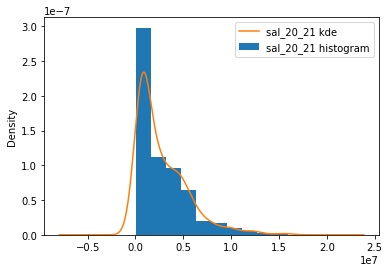

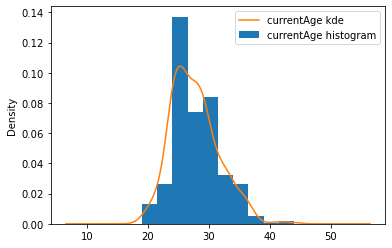

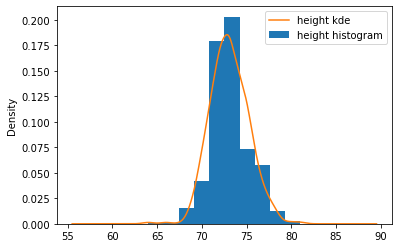

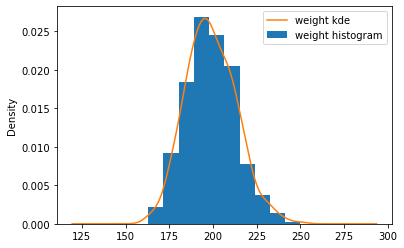

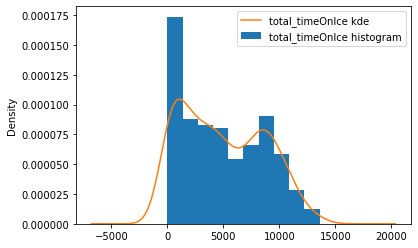

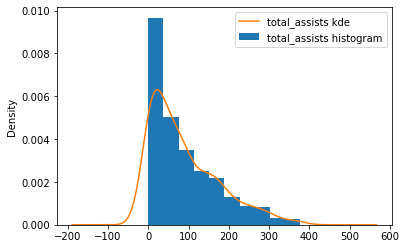

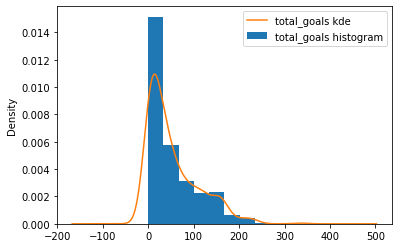

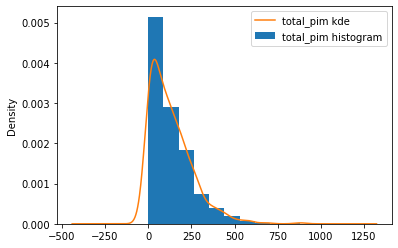

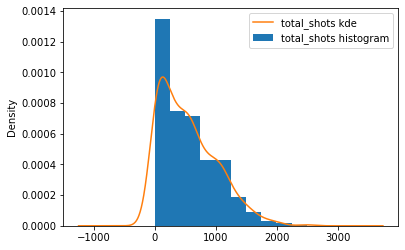

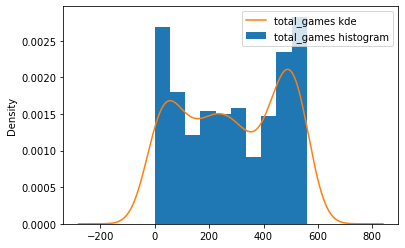

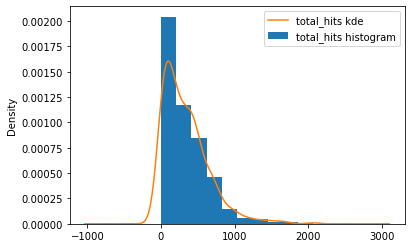

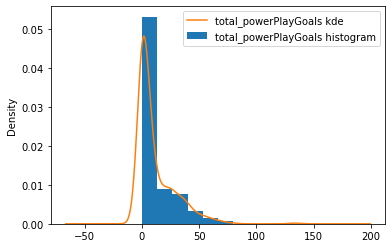

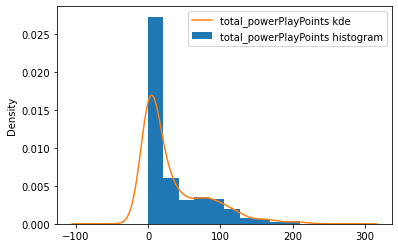

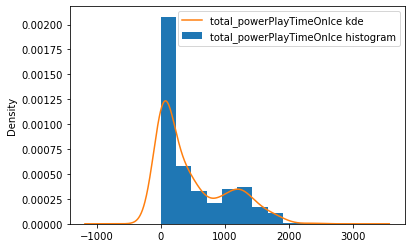

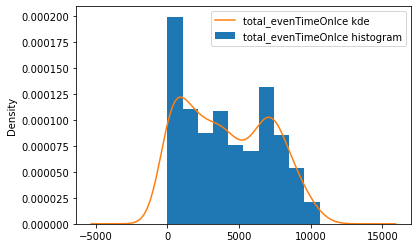

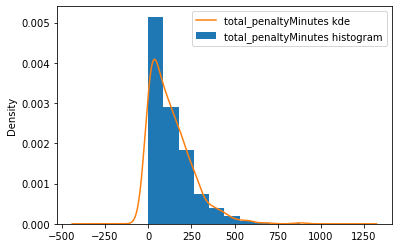

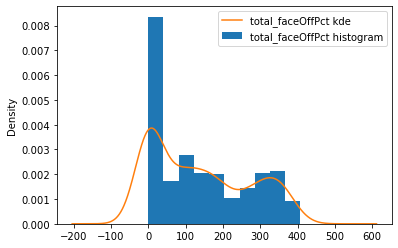

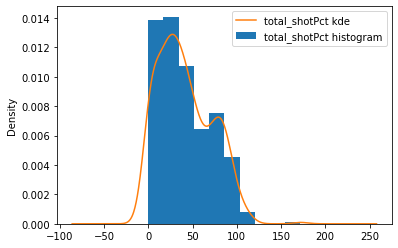

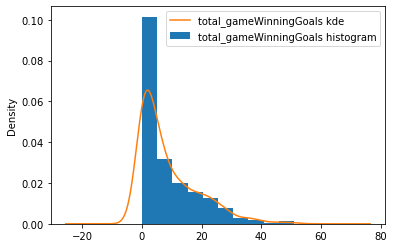

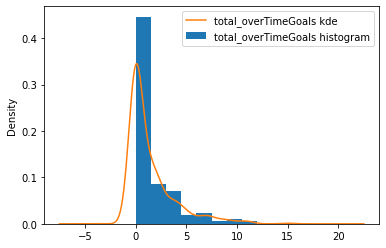

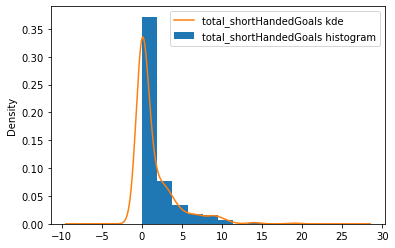

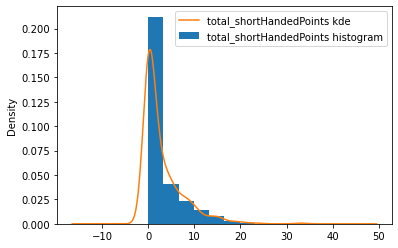

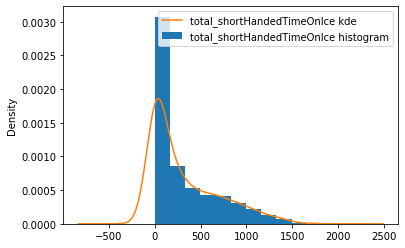

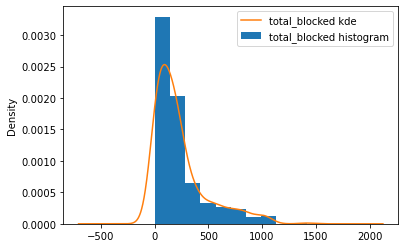

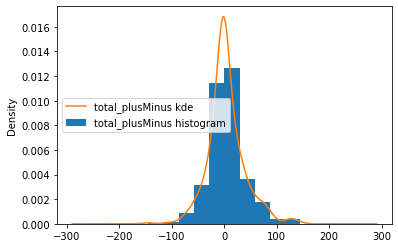

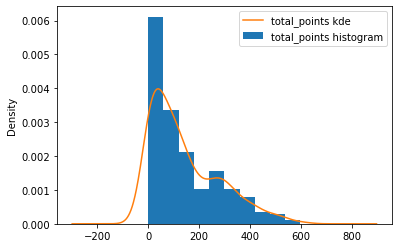

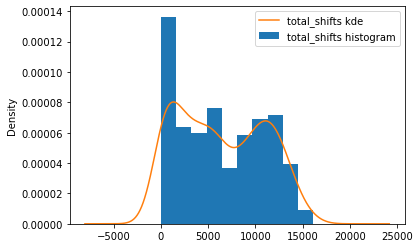

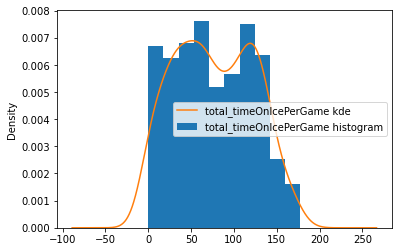

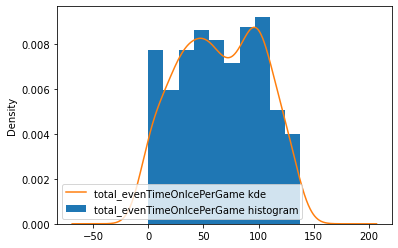

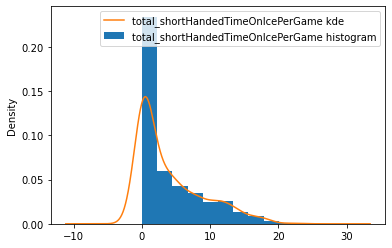

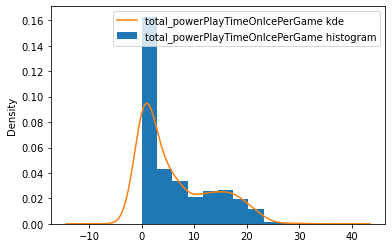

In [37]:
for column in cum_df:
    df_no_cats[column].plot.hist(density=True, label = column+' histogram')
    df_no_cats[column].plot.kde(label =column+' kde')
    plt.legend()
    plt.show()

# Above we can see that the data is not normally distributed. We will have to use a transformer below in our pipeline

In [38]:
pf = PolynomialFeatures(degree=2)

X = cum_df


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
x = corr_df[corr_df['x0'] > .50]['x0'].sort_values(ascending=False)
x.head(50)

x0        1.00
x0 x2     1.00
x0 x3     0.99
x0 x1     0.98
x0 x28    0.93
x0 x9     0.93
x0 x27    0.92
x0^2      0.92
x0 x14    0.92
x0 x26    0.91
x0 x4     0.91
x0 x25    0.89
x0 x8     0.88
x0 x5     0.88
x0 x30    0.88
x0 x17    0.88
x0 x13    0.87
x0 x6     0.84
x0 x12    0.84
x0 x18    0.83
x0 x11    0.77
x0 x7     0.76
x0 x15    0.76
x0 x16    0.76
x0 x19    0.74
x2 x25    0.73
x25       0.73
x2 x5     0.72
x5        0.72
x3 x25    0.72
x3 x5     0.72
x2 x12    0.70
x12       0.70
x3 x12    0.70
x25 x28   0.69
x25 x27   0.69
x14 x25   0.69
x4 x25    0.69
x2 x13    0.69
x13       0.69
x0 x10    0.68
x3 x13    0.68
x2 x30    0.68
x5 x28    0.68
x5 x14    0.68
x25 x26   0.67
x30       0.67
x3 x30    0.67
x5 x27    0.67
x4 x5     0.67
Name: x0, dtype: float64

In [39]:
cum_df.head()

,sal_20_21,currentAge,height,weight,total_timeOnIce,total_assists,total_goals,total_pim,total_shots,total_games,total_hits,total_powerPlayGoals,total_powerPlayPoints,total_powerPlayTimeOnIce,total_evenTimeOnIce,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_gameWinningGoals,total_overTimeGoals,total_shortHandedGoals,total_shortHandedPoints,total_shortHandedTimeOnIce,total_blocked,total_plusMinus,total_points,total_shifts,total_timeOnIcePerGame,total_evenTimeOnIcePerGame,total_shortHandedTimeOnIcePerGame,total_powerPlayTimeOnIcePerGame
0,8000000.00,32,72.00,210,12478.50,239.00,73.00,495.00,1218.00,511.00,667.00,26.00,125.00,1746.23,9775.47,495.00,33.33,41.86,14.00,2.00,1.00,3.00,955.60,706.00,15.00,312.00,14387.00,169.45,132.63,11.83,22.13
1,4700000.00,27,73.00,206,7060.60,95.00,15.00,104.00,349.00,347.00,175.00,5.00,23.00,456.46,5893.61,104.00,0.00,37.89,0.00,0.00,0.00,2.00,708.13,593.00,13.00,110.00,8756.00,137.84,117.60,12.81,6.16
2,4675000.00,26,74.00,205,8942.67,126.00,37.00,264.00,693.00,430.00,435.00,6.00,51.00,872.87,7647.61,264.00,0.00,30.81,5.00,0.00,0.00,1.00,419.79,394.00,-107.00,163.00,11175.00,123.86,105.79,5.16,10.87
3,1500000.00,27,71.00,192,3632.25,35.00,12.00,152.00,258.00,230.00,223.00,2.00,5.00,103.62,3431.64,152.00,0.00,31.65,6.00,0.00,0.00,0.00,94.19,283.00,-20.00,47.00,4842.00,92.89,87.21,2.02,1.58
4,3600000.00,26,70.00,190,3807.59,82.00,13.00,32.00,258.00,215.00,90.00,4.00,38.00,502.63,3277.71,32.00,0.00,15.88,3.00,0.00,0.00,0.00,26.45,211.00,-24.00,95.00,4752.00,52.74,45.67,0.22,6.01


In [40]:
cum_df['assist_height'] = cum_df['height'] * cum_df['total_assists']

In [41]:
multi_form = 'sal_20_21 ~' + '+'.join(cum_df.columns[1:])
multiple_model = ols(multi_form, cum_df).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     29.72
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.02e-86
Time:                        07:20:55   Log-Likelihood:                -7638.7
No. Observations:                 487   AIC:                         1.534e+04
Df Residuals:                     457   BIC:                         1.546e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          6.539e+06    3.9e+06      1.678      0.094   -1.12e+06    1.42e+07
currentAge                        -2.131e+05      3e+04     -7.113      0.000   -2.72e+05   -1.54e+05
height                             6196.6720   6.05e+04      0.102      0.919   -1.13e+05    1.25e+05
weight                            -5098.1885   8586.261     -0.594      0.553    -2.2e+04    1.18e+04
total_timeOnIce                   -3401.8161   1.47e+05     -0.023      0.982   -2.92e+05    2.85e+05
total_assists                     -2.924e+04   2.14e+04     -1.368      0.172   -7.12e+04    1.28e+04
total_goals                         3.94e+04   1.29e+04      3.045      0.002     1.4e+04    6.48e+04
total_pim                         -1088.4097    560.875     -1.941      0.053   -2190.623      13.804
total_shots                        -986.3133    872.228     -1.131      0.259   -2700.388     727.761
total_games                       -9873.8441   4052.873     -2.436      0.015   -1.78e+04   -1909.266
total_hits                          774.1612    485.292      1.595      0.111    -179.519    1727.842
total_powerPlayGoals              -5.228e+04   2.37e+04     -2.202      0.028   -9.89e+04   -5620.072
total_powerPlayPoints              2.846e+04    1.2e+04      2.364      0.019    4795.991    5.21e+04
total_powerPlayTimeOnIce           1557.7547   1.47e+05      0.011      0.992   -2.87e+05    2.91e+05
total_evenTimeOnIce                4539.1542   1.47e+05      0.031      0.975   -2.84e+05    2.93e+05
total_penaltyMinutes              -1088.4097    560.875     -1.941      0.053   -2190.623      13.804
total_faceOffPct                   1271.7697   1437.289      0.885      0.377   -1552.746    4096.285
total_shotPct                     -1046.0340   6631.935     -0.158      0.875   -1.41e+04     1.2e+04
total_gameWinningGoals            -4.188e+04   3.17e+04     -1.321      0.187   -1.04e+05    2.04e+04
total_overTimeGoals               -8.208e+04   6.39e+04     -1.285      0.199   -2.08e+05    4.34e+04
total_shortHandedGoals            -6.558e+04   8.95e+04     -0.733      0.464   -2.41e+05     1.1e+05
total_shortHandedPoints            5.605e+04   6.08e+04      0.921      0.357   -6.35e+04    1.76e+05
total_shortHandedTimeOnIce         3553.5533   1.47e+05      0.024      0.981   -2.85e+05    2.92e+05
total_blocked                      1388.2277   1063.086      1.306      0.192    -700.915    3477.370
total_plusMinus                    5637.0389   3042.630      1.853      0.065    -342.242    1.16e+04
total_points                       1.017e+04    1.1e+04      0.923      0.356   -1.15e+04    3.18e+04
total_shifts                       -326.1525    256.422     -1.272      0.204    -830.065     177.760
total_timeOnIcePerGame 

# Train Test Split

In [42]:
X_1 = df_no_cats.drop('sal_20_21', axis=1)
y_1 = df_no_cats['sal_20_21']

In [43]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=42)

In [44]:
cum_df_full = pd.read_csv('cumulative_df.csv')
cum_df_full.head()

,Unnamed: 0,currentAge,height,weight,sal_20_21,total_timeOnIce,total_assists,total_goals,total_pim,total_shots,total_games,total_hits,total_powerPlayGoals,total_powerPlayPoints,total_powerPlayTimeOnIce,total_evenTimeOnIce,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_gameWinningGoals,total_overTimeGoals,total_shortHandedGoals,total_shortHandedPoints,total_shortHandedTimeOnIce,total_blocked,total_plusMinus,total_points,total_shifts,total_timeOnIcePerGame,total_evenTimeOnIcePerGame,total_shortHandedTimeOnIcePerGame,total_powerPlayTimeOnIcePerGame
0,0,32,72.00,210,8000000.00,12478.50,239.00,73.00,495.00,1218.00,511.00,667.00,26.00,125.00,1746.23,9775.47,495.00,33.33,41.86,14.00,2.00,1.00,3.00,955.60,706.00,15.00,312.00,14387.00,169.45,132.63,11.83,22.13
1,1,27,73.00,206,4700000.00,7060.60,95.00,15.00,104.00,349.00,347.00,175.00,5.00,23.00,456.46,5893.61,104.00,0.00,37.89,0.00,0.00,0.00,2.00,708.13,593.00,13.00,110.00,8756.00,137.84,117.60,12.81,6.16
2,2,26,74.00,205,4675000.00,8942.67,126.00,37.00,264.00,693.00,430.00,435.00,6.00,51.00,872.87,7647.61,264.00,0.00,30.81,5.00,0.00,0.00,1.00,419.79,394.00,-107.00,163.00,11175.00,123.86,105.79,5.16,10.87
3,3,27,71.00,192,1500000.00,3632.25,35.00,12.00,152.00,258.00,230.00,223.00,2.00,5.00,103.62,3431.64,152.00,0.00,31.65,6.00,0.00,0.00,0.00,94.19,283.00,-20.00,47.00,4842.00,92.89,87.21,2.02,1.58
4,4,26,70.00,190,3600000.00,3807.59,82.00,13.00,32.00,258.00,215.00,90.00,4.00,38.00,502.63,3277.71,32.00,0.00,15.88,3.00,0.00,0.00,0.00,26.45,211.00,-24.00,95.00,4752.00,52.74,45.67,0.22,6.01


In [45]:
X = cum_df_full.drop(['sal_20_21', 'Unnamed: 0'], axis=1)
y = cum_df_full['sal_20_21']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

# Linear Regression

In [47]:
pipe = Pipeline([('scaler', MinMaxScaler()),
               ('model', LinearRegression())])
param_grid={}

gs = GridSearchCV(pipe,param_grid, n_jobs=-1, cv=10,\
                 return_train_score=True)

gs.fit(X_train, y_train)

lr_train_pred = gs.predict(X_train)
lr_test_pred = gs.predict(X_test)

print('RMSE Train:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('RMSE Test:', np.sqrt(mean_squared_error(y_test, lr_test_pred)))
print('R2 Train Score:', r2_score(y_train, lr_train_pred))
print('R2 Test Score:', r2_score(y_test, lr_test_pred))

RMSE Train: 1446076.7623919225
RMSE Test: 1972707.7270477752
R2 Train Score: 0.7132000681491251
R2 Test Score: 0.4069457015482645


# Lazy Regressor

In [48]:
lazy_reg = LazyRegressor(predictions=True, random_state=42)

models, predictions = lazy_reg.fit(X_train_1, X_test_1, y_train_1, y_test_1)

models

100%|██████████| 41/41 [00:10<00:00,  4.03it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,9665430237691155194795418380199357403103232.00,-7828199696642423716933991125976615665795072.00,7167149518561166143336218624.00,0.13
LinearSVR,3.68,-1.17,3770681.99,0.02
MLPRegressor,3.67,-1.17,3769171.46,0.42
GaussianProcessRegressor,3.66,-1.16,3763000.04,0.07
RANSACRegressor,3.62,-1.12,3732845.48,1.03
KernelRidge,3.61,-1.11,3720853.84,0.02
PoissonRegressor,3.32,-0.88,3509806.26,0.03
PassiveAggressiveRegressor,3.21,-0.79,3423659.76,0.25
SVR,2.49,-0.21,2815038.00,0.06


In [49]:
lazy_reg = LazyRegressor(predictions=True, random_state=42)

models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 41/41 [00:03<00:00, 13.01it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.31,0.48,1840241.81,0.22
GradientBoostingRegressor,0.29,0.47,1873665.47,0.19
OrthogonalMatchingPursuitCV,0.28,0.46,1881828.71,0.01
XGBRegressor,0.28,0.46,1883966.08,0.20
OrthogonalMatchingPursuit,0.28,0.46,1887104.86,0.01
LassoLarsCV,0.25,0.43,1927157.80,0.06
LassoLars,0.25,0.43,1927157.80,0.02
RandomForestRegressor,0.24,0.43,1930919.33,0.37
LassoLarsIC,0.24,0.43,1940642.12,0.02


In [50]:
X_train

,currentAge,height,weight,total_timeOnIce,total_assists,total_goals,total_pim,total_shots,total_games,total_hits,total_powerPlayGoals,total_powerPlayPoints,total_powerPlayTimeOnIce,total_evenTimeOnIce,total_penaltyMinutes,total_faceOffPct,total_shotPct,total_gameWinningGoals,total_overTimeGoals,total_shortHandedGoals,total_shortHandedPoints,total_shortHandedTimeOnIce,total_blocked,total_plusMinus,total_points,total_shifts,total_timeOnIcePerGame,total_evenTimeOnIcePerGame,total_shortHandedTimeOnIcePerGame,total_powerPlayTimeOnIcePerGame
459,29,72.00,182,3946.96,40.00,14.00,34.00,278.00,209.00,183.00,4.00,12.00,279.18,3493.55,34.00,0.00,17.14,0.00,0.00,0.00,0.00,171.83,356.00,-27.00,54.00,4917.00,108.82,97.97,3.08,5.35
131,22,73.00,201,53.45,0.00,0.00,0.00,9.00,3.00,3.00,0.00,0.00,8.24,45.21,0.00,61.22,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,69.00,17.55,15.07,0.00,2.48
57,24,73.00,191,1976.58,27.00,30.00,32.00,270.00,134.00,126.00,5.00,8.00,188.74,1677.00,32.00,70.62,31.35,3.00,0.00,0.00,0.00,109.64,81.00,-1.00,57.00,2747.00,45.15,38.09,1.76,4.48
181,25,74.00,191,437.16,6.00,0.00,6.00,39.00,40.00,45.00,0.00,0.00,3.02,365.11,6.00,42.77,0.00,0.00,0.00,0.00,1.00,69.03,21.00,-7.00,6.00,665.00,10.55,9.07,1.43,0.04
317,30,76.00,208,7153.65,93.00,86.00,296.00,720.00,512.00,544.00,26.00,52.00,918.43,5786.46,296.00,205.52,84.58,13.00,1.00,4.00,8.00,445.16,162.00,-33.00,179.00,9719.00,95.99,77.25,4.43,11.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,25,74.00,193,7163.01,146.00,109.00,80.00,858.00,400.00,172.00,36.00,75.00,1235.21,5910.89,80.00,209.46,64.31,14.00,0.00,0.00,0.00,14.91,187.00,-69.00,255.00,8354.00,99.84,83.74,0.10,14.73
270,23,72.00,189,1267.94,6.00,6.00,38.00,97.00,68.00,57.00,1.00,1.00,22.53,1212.59,38.00,0.00,25.40,0.00,0.00,0.00,0.00,32.02,91.00,-8.00,12.00,1564.00,31.45,30.41,0.42,0.21
348,24,73.00,208,3610.41,86.00,75.00,52.00,582.00,197.00,76.00,23.00,54.00,675.31,2928.97,52.00,105.63,54.14,11.00,1.00,0.00,0.00,4.93,60.00,-3.00,161.00,4485.00,70.84,58.17,0.04,11.40
435,24,78.00,241,2120.43,33.00,20.00,83.00,206.00,154.00,157.00,0.00,3.00,74.00,1984.77,83.00,93.82,19.61,1.00,0.00,0.00,0.00,60.86,87.00,-10.00,53.00,2788.00,38.72,36.29,0.56,0.65


In [ ]:
model = ExtraTreesRegressor(n_jobs=-1)
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid={
        'n_estimators': range(50,375,25),
        'max_features': range(0,40,5),
        'min_samples_leaf': range(0,50,5),
        'min_samples_split': range(0,50,5),
    },
    scoring='r2',
    cv=5
)

grid_result = gsc.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# for test_mean, train_mean, param in zip(
#         grid_result.cv_results_['mean_test_score'],
#         grid_result.cv_results_['mean_train_score'],
#         grid_result.cv_results_['params']):
#     print("Train: %f // Test : %f with: %r" % (train_mean, test_mean, param))
    
# model = ExtraTreesRegressor(**grid_result.best_params_)

# model.fit(train, y_train)

# df_sub = pd.DataFrame({'ID': id_test, 'y': model.predict(test)})
# df_sub.to_csv('mercedes-submission.csv', index=False)


In [ ]:
gbr = GradientBoostingRegressor()
omp = OrthogonalMatchingPursuitCV()
xgbr = XGBRegressor()